## Hyperparameter scan for mo's ontogeny dataset

KPSN version `kaijfox/size-norm#5c88d90`

In [1]:
%load_ext autoreload
%autoreload 3 --print
# import os; os.environ['JAX_PLATFORM_NAME'] = 'cpu'
# import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
from kpsn.project.paths import Project, create_model
from kpsn.io import loaders
from kpsn.models import joint
from kpsn import config
from kpsn.models import instantiation, setup, pose, morph, util as model_util
from kpsn import fitting
from kpsn.fitting import em
from kpsn.io import alignment, features
from kpsn.io.armature import Armature
from kpsn.fitting import methods
from kpsn.fitting import scans
from kpsn.io.dataset import PytreeDataset
import os, sys, shutil
from pprint import pprint
from kpsn import viz
import numpy as np
from kpsn.viz import styles
import matplotlib.pyplot as plt
from collections import defaultdict
import os, re
import tqdm
import joblib as jl

from pathlib import Path
import logging
logging.getLogger().setLevel(logging.INFO)

In [3]:
# Define paths

data_root = '../../../data_explore/data'

project_dir = Path('../projects/moont-full-lock')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')

In [4]:
# Create mapping of session names (ie 3wk_m0) to keypoint data paths

modata_npy_name_func = (lambda path, *a:
    match.group(1) if ((match := re.search(r"\d{2}_\d{2}_\d{2}_(\d+wk_m\d+)\.npy", path)) is not None) else None)
session_paths = dict(filter(lambda x: x[0] is not None, [(modata_npy_name_func(m), str(Path(data_root) / m)) for m in os.listdir(data_root)]))
# throw out 9-12 week
session_ages = {s: s.split('_')[0].strip('wk') for s in session_paths}
ages = set(session_ages.values())
ages = list(filter(lambda x: x not in ["5", "7", "9", "12", "24", "52", "72"], ages))
session_paths = {s: p for s, p in session_paths.items() if session_ages[s] in ages}
session_bodies = {s: f'body-{session_ages[s]}wk' for s in session_paths}
ref_age = "3"

age_dates =  {
    "3" : "10_11_22",
    "5" : "10_24_22",
    "7" : "10_24_22",
    "24": "11_03_22",
    "52" : "11_03_22",
    "72" : "10_14_22",
}

print("sessions:", session_paths.keys())

raw_keypoints = {
    s: np.load(p) for s, p in session_paths.items()
}

sessions: dict_keys(['3wk_m1', '3wk_m0', '3wk_m2', '3wk_m3'])


### Project setup

In [37]:
# Create base project config to override

loaders.arrays.setup_project_config(
    project.main_config(),
    session_names = list(session_paths.keys()),
    # filepaths=session_paths,
    ref_session = f'{ref_age}wk_m0',
    keypoint_names = [
        'shldr', 'back', 'hips', 't_base','t_tip', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot'],
    keypoint_parents = [
        'back', 'hips', None, 'hips', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr'],
    bodies = session_bodies,
    anterior = 'nose',
    posterior = 'hips',
    exclude_keypoints = ['t_tip'],
    subsample = 100,
    feature_type='pcs',)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

In [38]:
# Run calibration for base model to decide on PCs / number of GMM components

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
# dataset = loaders.raw_npy.load(cfg["dataset"])
dataset = loaders.arrays.from_arrays(raw_keypoints, cfg["dataset"])

dataset, cfg = loaders.arrays.default_alignment.calibrate(
    dataset, cfg, origin="hips", anterior="head"
)

cfg = features.pcs.calibrate(dataset, cfg, n_dims=12)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["calibration"]["tgt_variance"] = 0.95
cfg["fit"]["n_steps"] = 400

# cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=20) ### !! for poseL20 project
cfg = pose.gmm.calibrate_base_model(dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)


INFO:root:Fitting GMM to 360 frames
INFO:root:Fitting GMM to 360 frames
INFO:root:Fitting GMM to 360 frames
INFO:root:Fitting GMM to 360 frames


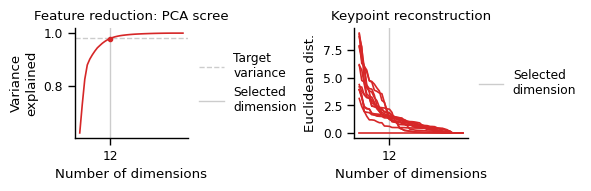

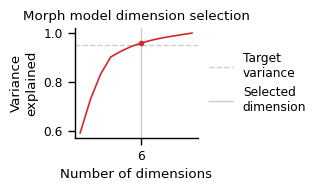

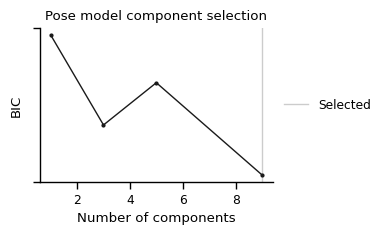

PosixPath('../projects/moont-full-lock/plots/pose_calibration.pdf')

In [39]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

### Dataset visualizations

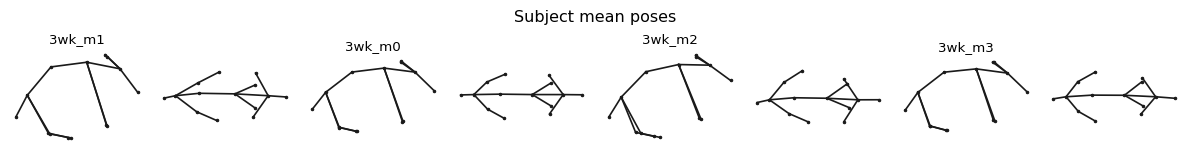

In [40]:
# load fully calibrated dataset, as well as aligned / feature reduced versions
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(raw_keypoints, cfg["dataset"])
datasets, _ = methods.prepare_dataset(dataset, cfg, modify = False, all_versions = True)

fig = viz.general.session_means(cfg, datasets['aligned'])
plotter.finalize(fig, None, despine = False)

### Hyperparmeter scan

In [41]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "unif-scan", {
    # 'morph.upd_var_modes': [1e-3, 3e-2, 3e-1], #, 3e0
    # 'morph.upd_var_ofs': [5e-3, 1e-1, 1e0], #, 1e1
    # 'morph.dist_var': [1e-3, 1e-2, 1e3]
    'pose.subj_weight_uniformity': [1, 10]
}, model_overrides={
    'fit.learning_rate': 8,
    'fit.n_steps': 2000,
    # 'fit.update_blacklist': ('pose/means', 'pose/cholesky')
    'morph.prior_mode': 'points',
    'morph.dist_var': 1e-1 # resolved from prior scan, fixed for `unif-scan`
})

# scan_cfg, model_cfg = scans.setup_scan_config(project, "prior-scan_2", {
#     'morph.upd_var_modes': [3e-1],
#     'morph.upd_var_ofs': [1e0],
# }, model_overrides={
#     'fit.learning_rate': 8,
#     'fit.n_steps': 1000,
# })

In [42]:
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(raw_keypoints, cfg["dataset"])
dataset, _, _ = scans.prepare_scan_dataset(dataset, project, "unif-scan")
scans.run_scan(project, "unif-scan", dataset, log_every=1)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 360 frames
INFO:root:Adjusting learning rate:8 -> 0.005555555555555556
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 61903.30078125
INFO:root:Step 1 : loss = 59532.91015625
INFO:root:Step 2 : loss = 58951.25
INFO:root:Step 3 : loss = 58596.25390625
INFO:root:Step 4 : loss = 58332.8984375
INFO:root:Step 5 : loss = 58128.4375
INFO:root:Step 6 : loss = 58006.16015625
INFO:root:Step 7 : loss = 57937.94921875
INFO:root:Step 8 : loss = 57897.73046875
INFO:root:Step 9 : loss = 57870.28125
INFO:root:Step 10 : loss = 57848.33984375
INFO:root:Step 11 : loss = 57839.1171875
INFO:root:Step 12 : loss = 57830.0546875


KeyboardInterrupt: 

##### continuation

In [13]:
model_name = "prior-scan_0"
cfg = config.load_model_config(project.model_config(model_name))
cfg['fit']['em']['n_steps'] = 6000
config.save_model_config(project.model_config(model_name), cfg)

In [14]:
methods.fit(project.model(model_name));

INFO:root:Continuing from checkpoint at step 2999.
INFO:root:Adjusting learning rate:8 -> 0.00012371452872496713
INFO:root:Loading LR schedule: const


{'params': <kpsn.models.joint.JointModelParams at 0x7fed6c125d60>,
 'meta': {'loss': Array([2644862. , 2616149. , 2604282.5, ..., 2531192.8, 2531192.8,
         2531192.5], dtype=float32, weak_type=True),
  'gd_step': Array([ 400.,  800., 1200., ...,   nan,   nan,   nan],      dtype=float32, weak_type=True),
  'mstep_length': Array([400., 400., 400., ...,  27.,  27.,  27.], dtype=float32, weak_type=True),
  'walltime': Array([47.01872 , 49.108185, 51.16167 , ...,       nan,       nan,
               nan], dtype=float32, weak_type=True),
  'opt_state': InjectHyperparamsState(count=Array(222489, dtype=int32), hyperparams={'b1': Array(0.9, dtype=float32), 'b2': Array(0.999, dtype=float32), 'eps': Array(1.e-08, dtype=float32), 'eps_root': Array(0., dtype=float32), 'learning_rate': Array(0.00012371, dtype=float32)}, inner_state=(ScaleByAdamState(count=Array(222489, dtype=int32), mu=((Array([[ 7.5685867e-04,  6.9664693e-06, -6.4350592e-05, -1.2654880e-05,
          -5.6420313e-04,  6.5392873

### Scan results

Plotting prior-scan_0
- reports
../projects/moont-7.24/models/prior-scan_0/reports.pdf


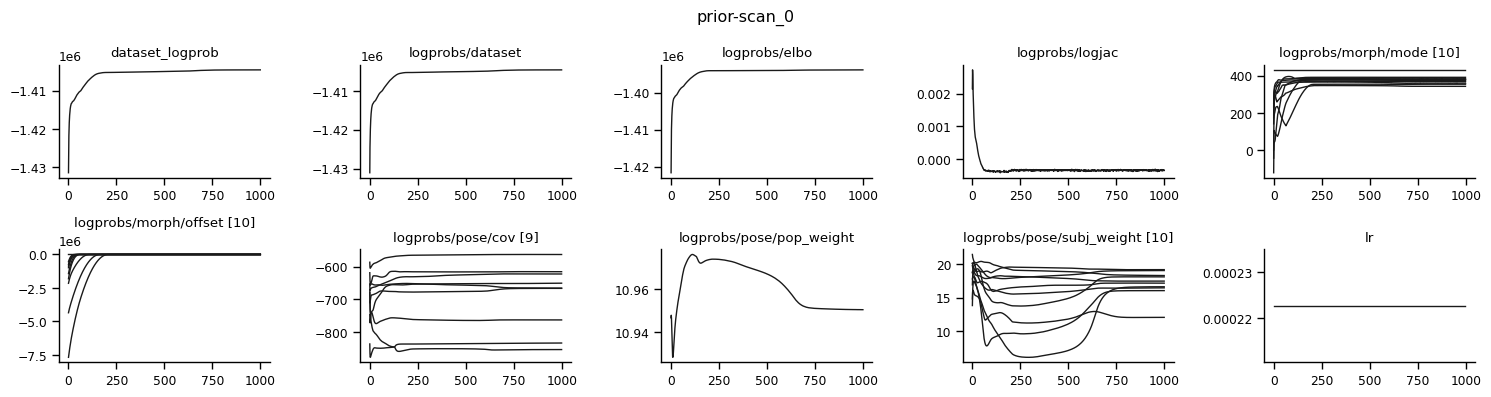

../projects/moont-7.24/models/prior-scan_0/em_loss.pdf


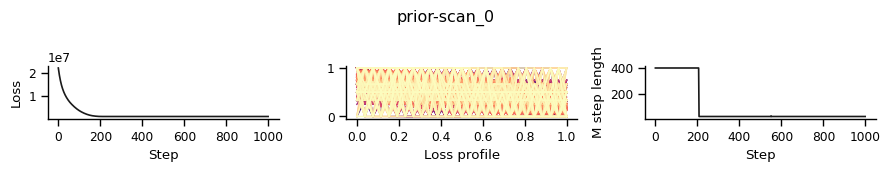

Plotting prior-scan_1
- reports
../projects/moont-7.24/models/prior-scan_1/reports.pdf


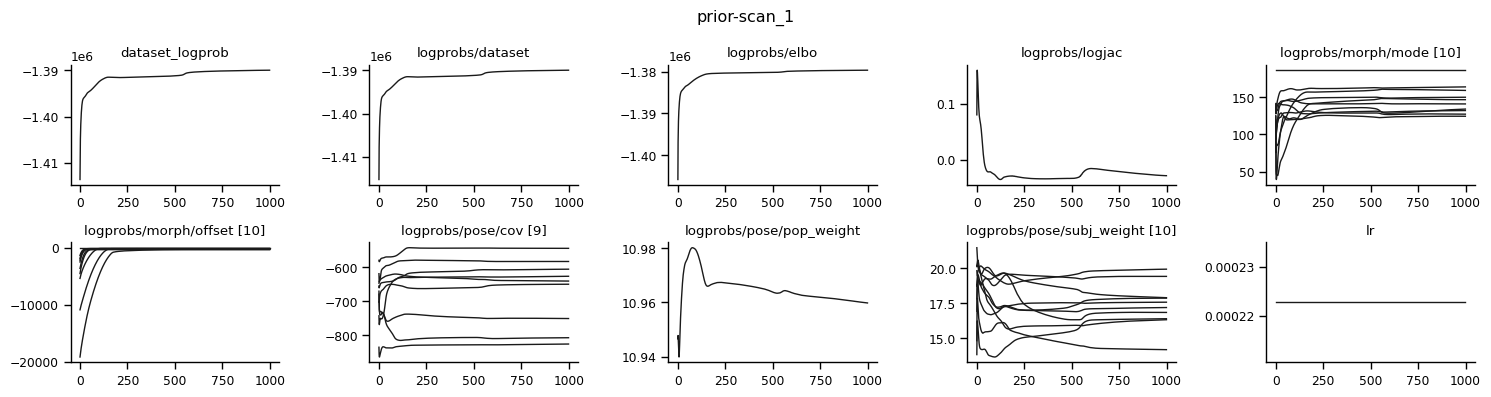

../projects/moont-7.24/models/prior-scan_1/em_loss.pdf


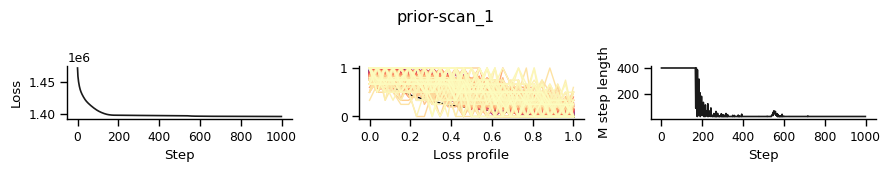

Plotting prior-scan_2
- reports
../projects/moont-7.24/models/prior-scan_2/reports.pdf


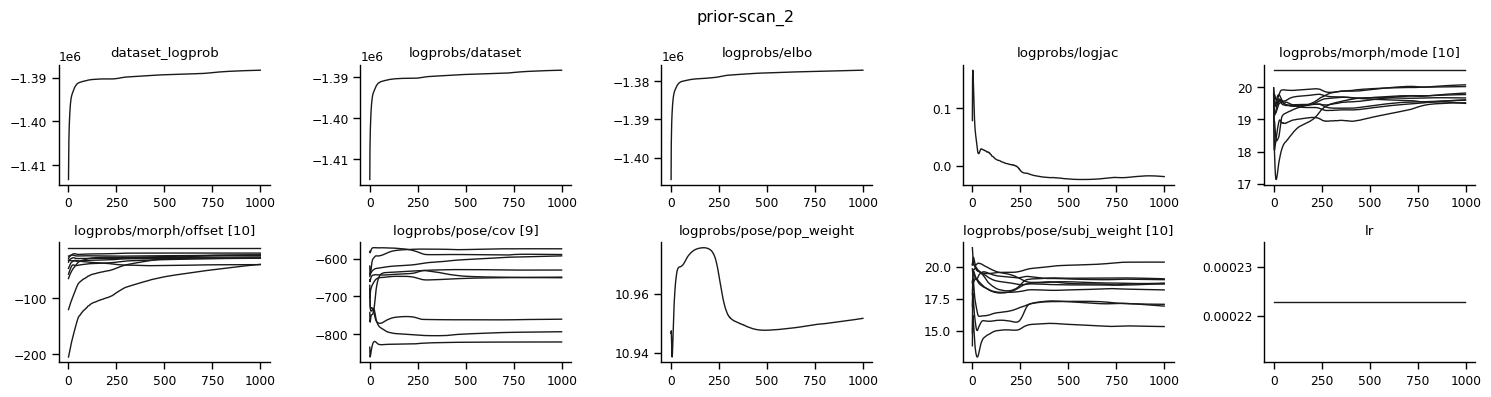

KeyboardInterrupt: 

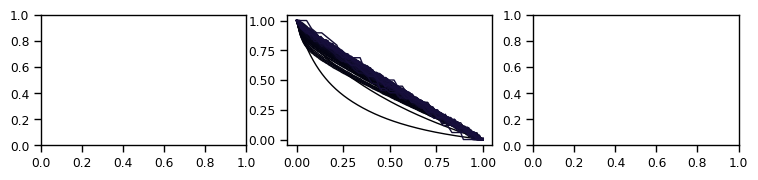

In [15]:
scan_cfg = config.load_config(project.scan("prior-scan") / "scan.yml")
for model_name in scan_cfg['models'].keys():
    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    plotter.plot_dir = str(project.model(model_name))

    print("- reports")
    fig = viz.model.report_plots(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    # print("- morph")
    # fig = viz.model.lra_param_convergence(ckpt)
    # fig.suptitle(model_name)
    # plotter.finalize(fig, "morph_convergence")

    # print("- gmm")
    # fig = viz.model.gmm_param_convergence(ckpt)
    # fig.suptitle(model_name)
    # plotter.finalize(fig, "gmm_convergence")

    # mean_fig, wt_fig = viz.model.gmm_components(ckpt)
    # mean_fig.suptitle(model_name)
    # wt_fig.suptitle(model_name)
    # plotter.finalize(fig, "gmm_components")

PosixPath('../projects/mo-ontogeny-full/scans/prior-scan/plots')

Reloading 'kpsn.fitting.scans'.




  0%|                                                                   | 0/4 [00:00<?, ?it/s]

 25%|██████████████▊                                            | 1/4 [00:00<00:00,  4.34it/s]

 50%|█████████████████████████████▌                             | 2/4 [00:00<00:00,  3.12it/s]

 75%|████████████████████████████████████████████▎              | 3/4 [00:00<00:00,  3.40it/s]

100%|███████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.58it/s]


../projects/mo-ontogeny-full/scans/prior-scan/plots/reconst_errs.pdf


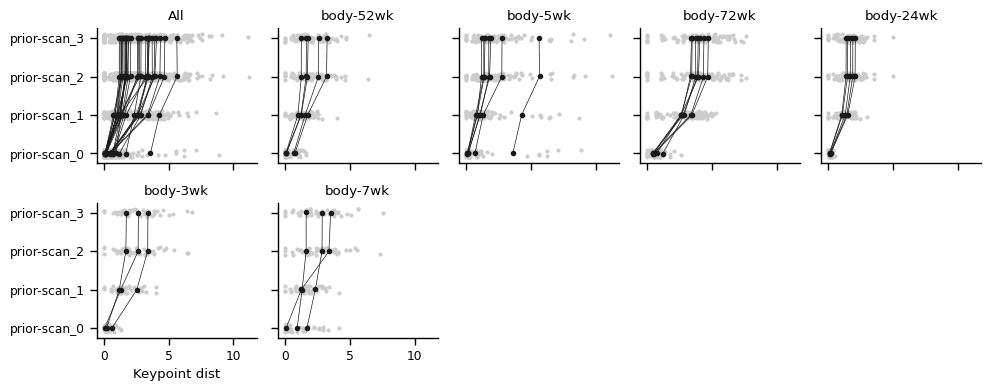

In [22]:
plotter.plot_dir = str(project.scan("prior-scan") / "plots")

fig = viz.scans.withinbody_induced_errs(project, "prior-scan", progress = True)
plotter.finalize(fig, "reconst_errs")

In [26]:
# fig = viz.scans.jsds_to_reference(project, "prior-scan", progress = True, data_only = True)
jsds, base_jsds, dataset = viz.scans.jsds_to_reference(project, "prior-scan", progress = True, data_only = True)
plotter.finalize(fig, "jsds_to_reference")

Reloading 'kpsn.viz.scans'.


Unmorphed: 100%|████████████████████████████████████████████████| 6/6 [00:28<00:00,  4.78s/it]


../projects/mo-ontogeny-full/scans/prior-scan/plots/jsds_to_reference.pdf


../projects/mo-ontogeny-full/scans/prior-scan/plots/jsds_to_reference.pdf


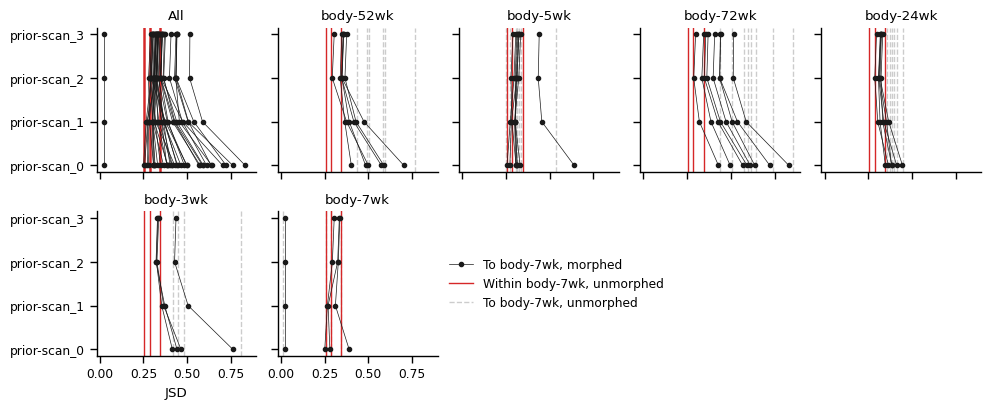

In [34]:
fig = viz.scans.jsds_to_reference(project, "prior-scan", progress = True, with_data = (jsds, base_jsds, dataset))
plotter.finalize(fig, "jsds_to_reference", tight = False)

Reloading 'kpsn.viz.scans'.


'body-7wk'

### Scan with all videos split two ways

In [17]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "split-all", {
    'morph.upd_var_modes': [1e-3, 3e-2, 3e-1, 3e0],
    'morph.upd_var_ofs': [5e-3, 1e-1, 1e0, 1e1],
}, model_overrides={
    'fit.learning_rate': 8,
    'fit.n_steps': 400,
}, scan_config_overrides={
    'split_all': True
})

In [39]:
scans.run_scan(project, "split-all", log_every=1)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 1797 frames
INFO:root:Adjusting learning rate:8 -> 6.185822095756526e-05
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 352848768.0
INFO:root:Step 1 : loss = 350546720.0
INFO:root:Step 2 : loss = 348277568.0
INFO:root:Step 3 : loss = 346036992.0
INFO:root:Step 4 : loss = 343823392.0
INFO:root:Step 5 : loss = 341635136.0
INFO:root:Step 6 : loss = 339471104.0
INFO:root:Step 7 : loss = 337330592.0
INFO:root:Step 8 : loss = 335212992.0
INFO:root:Step 9 : loss = 333117312.0
INFO:root:Step 10 : loss = 331042848.0
INFO:root:Step 11 : loss = 328989024.0
INFO:root:Step 12 : loss = 326955264.0
INFO:root:Step 13 : loss = 324941248.0
INFO:root:Step 14 : loss = 322946752.0
INFO:root:Step 15 : loss = 320971392.0
INFO:root:Step 16 : loss = 319014912.0
INFO:root:Step 17 : loss = 317077248.0
INFO:root:Step 18 : loss = 315157952.0
INFO:root:Step 19 : loss = 313256928.0
INFO:root:Step 20 : loss =

In [14]:
from kpsn.fitting import scans

In [5]:
dataset, (_body_inv, _session_inv), _ = scans._dataset_and_bodies_inv(project, "split-all_0", return_session_inv = True)

I0000 00:00:1710183550.912291  145155 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2024-03-11 14:59:28.254255: W external/xla/xla/service/gpu/buffer_comparator.cc:1054] INTERNAL: ptxas exited with non-zero error code 65280, output: ptxas /tmp/tempfile-compute-g-17-147.o2.rc.hms.harvard.edu-a6e90496-145155-613672414c534, line 10; fatal   : Unsupported .version 7.8; current version is '7.7'
ptxas fatal   : Ptx assembly aborted due to errors

Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only be logged once.


got session


In [8]:
_session_inv

{'5wk_m1': ['5wk_m1.0', '5wk_m1.1'],
 '5wk_m4': ['5wk_m4.0', '5wk_m4.1'],
 '5wk_m6': ['5wk_m6.0', '5wk_m6.1'],
 '5wk_m5': ['5wk_m5.0', '5wk_m5.1'],
 '5wk_m0': ['5wk_m0.0', '5wk_m0.1'],
 '5wk_m7': ['5wk_m7.0', '5wk_m7.1'],
 '5wk_m3': ['5wk_m3.0', '5wk_m3.1'],
 '5wk_m2': ['5wk_m2.0', '5wk_m2.1'],
 '72wk_m7': ['72wk_m7.0', '72wk_m7.1'],
 '72wk_m4': ['72wk_m4.0', '72wk_m4.1'],
 '72wk_m0': ['72wk_m0.0', '72wk_m0.1'],
 '72wk_m1': ['72wk_m1.0', '72wk_m1.1'],
 '72wk_m5': ['72wk_m5.0', '72wk_m5.1'],
 '72wk_m6': ['72wk_m6.0', '72wk_m6.1'],
 '72wk_m3': ['72wk_m3.0', '72wk_m3.1'],
 '72wk_m2': ['72wk_m2.0', '72wk_m2.1'],
 '52wk_m2': ['52wk_m2.0', '52wk_m2.1'],
 '52wk_m5': ['52wk_m5.0', '52wk_m5.1'],
 '52wk_m1': ['52wk_m1.0', '52wk_m1.1'],
 '52wk_m3': ['52wk_m3.0', '52wk_m3.1'],
 '52wk_m0': ['52wk_m0.0', '52wk_m0.1'],
 '52wk_m4': ['52wk_m4.0', '52wk_m4.1'],
 '3wk_m0': ['3wk_m0.0', '3wk_m0.1'],
 '3wk_m3': ['3wk_m3.0', '3wk_m3.1'],
 '3wk_m2': ['3wk_m2.0', '3wk_m2.1'],
 '3wk_m1': ['3wk_m1.0', '3wk_m1.1

In [9]:
_body_inv, errs = scans.withinsession_induced_errs(
        project, "split-all", progress=True)

Reloading 'kpsn.viz.scans'.
got session


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.61s/it]


In [14]:
models = sorted(list(errs.keys()))
bodies = _body_inv.keys()
sessions = list(errs[models[0]].keys())

In [34]:
orig_sess_name = sessions[0]

err_data = defaultdict(list)
for orig_sess_name in sessions:
    for sess in errs[models[0]][orig_sess_name].keys():
        # should be exactly one entry in _body_inv containing `sess`
        body = list(filter(lambda kv: sess in kv[1], _body_inv.items()))
        if len(body) == 0:
            print("No data found for", sess)
        body = body[0][0]
        err_data[body].append(np.array([errs[m][orig_sess_name][sess] for m in models]))

Reloading 'kpsn.viz.scans'.


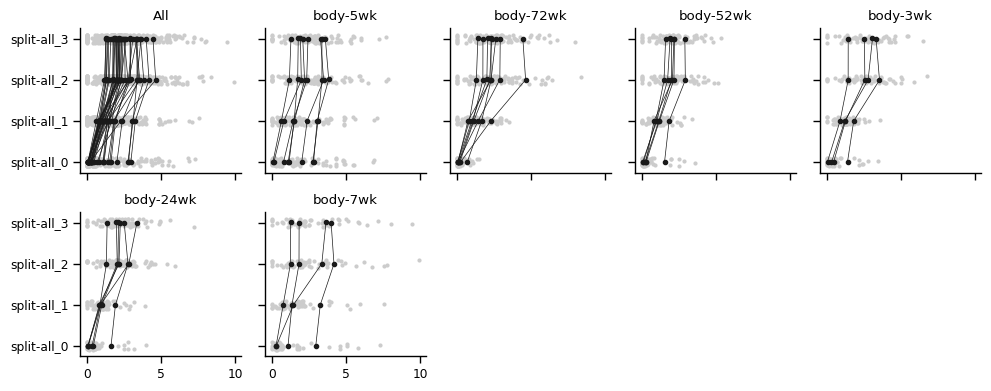

In [39]:
fig, ax, ax_grid = viz.scans._vertical_lineplot(err_data, labels = models)
plotter.finalize(fig, None)

In [ ]:
model = project.model("split-all_0")
(model / "plots").mkdir(exist_ok = True)
checkpoint = methods.load_fit(model)
checkpoint["config"] = config.load_model_config(model / "model.yml")
viz.model.display_clip_across_bodies(
    model / "plots" / "fit_clip.mp4",
    checkpoint,
    start = 300, 
    end = 800,
    window_size = 200, 
    source_session = "7wk_m0"
)


2024-03-11 16:02:59.798797: W external/xla/xla/service/gpu/buffer_comparator.cc:1054] INTERNAL: ptxas exited with non-zero error code 65280, output: ptxas /tmp/tempfile-compute-g-17-147.o2.rc.hms.harvard.edu-57aa4643-170727-6136807443af5, line 10; fatal   : Unsupported .version 7.8; current version is '7.7'
ptxas fatal   : Ptx assembly aborted due to errors

Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only be logged once.


video path /n/groups/datta/mo/multisize_data/10_24_22_7wk/10_24_22_7wk_m0/10_24_22_7wk_m0.top.ir.avi


### Map to reference body for moseq

In [23]:
# scaled, unmorphed data
model_name = "prior-scan_2"
output_dir = Path("../transformed_datasets/blscale") / project_dir.parts[-1] / "scale_only"
output_dir.mkdir(exist_ok = True, parents = True)

# load model and dataset
checkpoint = methods.load_fit(project.model(model_name))
dataset, align_inverse = methods.load_and_prepare_dataset(
    checkpoint["config"], allow_subsample=False, all_versions = True
)

aligned = alignment.invert_align(dataset['aligned'], align_inverse, checkpoint["config"]["alignment"], scale = False)


print(f"Saving: ({output_dir})")
for s in aligned.sessions:
    fname = Path(checkpoint["config"]["dataset"]["sessions"][s]["path"]).name
    print(f"> {s}: {fname}")
    np.save(output_dir / fname, aligned.get_session(s))

Saving: (../transformed_datasets/blscale/blscale-wk24_to7/scale_only)
> 24wk_m0: 11_03_22_24wk_m0.npy
> 24wk_m1: 11_03_22_24wk_m1.npy
> 24wk_m2: 11_03_22_24wk_m2.npy
> 24wk_m3: 11_03_22_24wk_m3.npy
> 24wk_m4: 11_03_22_24wk_m4.npy
> 24wk_m5: 11_03_22_24wk_m5.npy
> 7wk_m0: 10_24_22_7wk_m0.npy
> 7wk_m1: 10_24_22_7wk_m1.npy
> 7wk_m2: 10_24_22_7wk_m2.npy
> 7wk_m3: 10_24_22_7wk_m3.npy
> 7wk_m4: 10_24_22_7wk_m4.npy
> 7wk_m5: 10_24_22_7wk_m5.npy


In [9]:
model_name = "prior-scan_2"
output_dir = Path("../transformed_datasets/blscale") / project_dir.parts[-1] / model_name / "morphed-indiv"
output_dir.mkdir(exist_ok = True, parents = True)

# load model and dataset
checkpoint = methods.load_fit(project.model(model_name))
dataset, align_inverse = methods.load_and_prepare_dataset(
    checkpoint["config"], allow_subsample=False
)
morph = instantiation.get_model(checkpoint["config"]).morph
print("Loaded dataset.")

# select params
params = checkpoint["params"].morph
# params = jl.load(project.model(model_name) / "averaged_params.p").morph

# transform all bodies to the reference body
mapped = model_util.apply_bodies(
    morph,
    params,
    dataset,
    {s: dataset.sess_bodies[dataset.ref_session] for s in dataset.sessions},
)
print("Transformed sessions.")

Loaded dataset.
Transformed sessions.


In [10]:
# features -> unaligned keypoints
inflated = features.inflate(mapped, checkpoint["config"]["features"])
aligned = alignment.invert_align(inflated, align_inverse, checkpoint["config"]["alignment"], scale = False)

print("Saving to:", output_dir)
for s in dataset.sessions:
    fname = Path(checkpoint["config"]["dataset"]["sessions"][s]["path"]).name
    print(f"> {s}: {fname}")
    np.save(output_dir / fname, aligned.get_session(s))

Saving to: ../transformed_datasets/blscale/blscale-wk24_to7/prior-scan_2/morphed-indiv
> 24wk_m0: 11_03_22_24wk_m0.npy
> 24wk_m1: 11_03_22_24wk_m1.npy
> 24wk_m2: 11_03_22_24wk_m2.npy
> 24wk_m3: 11_03_22_24wk_m3.npy
> 24wk_m4: 11_03_22_24wk_m4.npy
> 24wk_m5: 11_03_22_24wk_m5.npy
> 7wk_m0: 10_24_22_7wk_m0.npy
> 7wk_m1: 10_24_22_7wk_m1.npy
> 7wk_m2: 10_24_22_7wk_m2.npy
> 7wk_m3: 10_24_22_7wk_m3.npy
> 7wk_m4: 10_24_22_7wk_m4.npy
> 7wk_m5: 10_24_22_7wk_m5.npy


### Hyperparameter scan with lower effective rank

In [7]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "lowrank-scan", {
    'morph.upd_var_modes': [3e-4, 3e-3, 3e-2, 3e-1],
    'morph.upd_var_ofs': [5e-3, 1e-1, 1e0, 1e1],
}, model_overrides={
    'fit.learning_rate': 8,
    'fit.n_steps': 1000,
})

In [ ]:
scans.run_scan(project, "lowrank-scan", log_every=1, force_restart=True)

INFO:root:Removing existing model ../projects/mo-ontogeny-full/models/lowrank-scan_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 3593 frames
INFO:root:Adjusting learning rate:8 -> 6.185822095756526e-05
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 123020944.0
INFO:root:Step 1 : loss = 122002848.0
INFO:root:Step 2 : loss = 121003200.0
INFO:root:Step 3 : loss = 120019928.0
INFO:root:Step 4 : loss = 119051464.0
INFO:root:Step 5 : loss = 118096464.0
INFO:root:Step 6 : loss = 117153952.0
INFO:root:Step 7 : loss = 116223400.0
INFO:root:Step 8 : loss = 115304424.0
INFO:root:Step 9 : loss = 114396560.0
INFO:root:Step 10 : loss = 113499352.0
INFO:root:Step 11 : loss = 112612584.0
INFO:root:Step 12 : loss = 111736072.0
INFO:root:Step 13 : loss = 110869480.0
INFO:root:Step 14 : loss = 110012528.0
INFO:root:Step 15 : loss = 109165168.0
INFO:root:Step 16 : loss = 108327232.0
INFO:root:Step 17 : loss = 107498560.0
INFO:root:Step 18 :